# Evaluation of the ResNet-50 model

## Import libraries

In [18]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from scivision.io import load_pretrained_model, load_dataset

## Load hold-out (test) dataset

In [6]:
cat = load_dataset('https://github.com/alan-turing-institute/plankton-dsg-challenge')

ds_all = cat.plankton_multiple().to_dask()
labels_holdout = cat.labels_holdout().read()

labels_holdout_dedup = xr.Dataset.from_dataframe(
    labels_holdout
    .drop_duplicates(subset=["filename"])
    .set_index("filename")
    .sort_index()
)

ds_holdout_labelled = (
    ds_all
    .swap_dims({"concat_dim": "filename"})
    .merge(labels_holdout_dedup, join="inner")
    .swap_dims({"filename": "concat_dim"})
)

In [7]:
print(ds_holdout_labelled)

<xarray.Dataset>
Dimensions:                               (channel: 3, concat_dim: 5863, x: 1040, y: 832)
Coordinates:
    filename                              (concat_dim) object 'Pia1.2016-08-0...
  * concat_dim                            (concat_dim) int64 13 18 ... 58748
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/27)
    raster                                (concat_dim, y, x, channel) uint8 dask.array<chunksize=(1, 832, 1040, 3), meta=np.ndarray>
    EXIF Image ImageWidth                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image ImageLength                (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image BitsPerSample              (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image Compressi

In [8]:
type(ds_holdout_labelled)

xarray.core.dataset.Dataset

In [26]:
ds_holdout_labelled.dims['concat_dim']

5863

In [9]:
# choose a test image
image_no = 18
image = ds_holdout_labelled['raster'].sel(concat_dim=image_no).compute().values
label_gt = ds_holdout_labelled['label3'].sel(concat_dim=image_no).compute().values

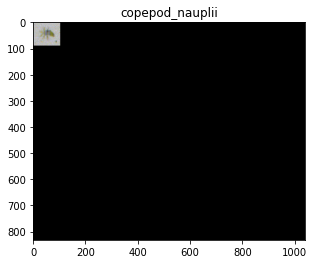

In [20]:
plt.figure()
plt.imshow(image)
plt.title("{}".format(label_gt))
plt.show()

## Load pretrained model

In [3]:
# Load model
scivision_yml = 'https://github.com/acocac/scivision-plankton-pytorch/.scivision-config.yaml'
model = load_pretrained_model(scivision_yml, allow_install=True)

## Preprocess image

In [4]:
# libraries
import torch
import torchvision

In [11]:
# resize image
IMAGE = torchvision.transforms.ToTensor()(image)
IMAGE = torchvision.transforms.Resize((256,256))(IMAGE)
IMAGE = torch.unsqueeze(IMAGE, 0)

In [12]:
# Get model predicition of image
pred = model.predict(IMAGE)

/home/alejandro.cocacastro/.local/lib/python3.8/site-packages/scivision_plankton_pytorch/model.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(image)


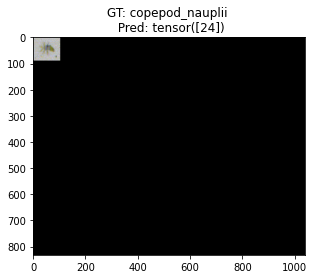

In [23]:
plt.figure()
plt.imshow(image)
_, preds = torch.max(pred, 1)
plt.title("GT: {} \n Pred: {}".format(label_gt, preds))
plt.show()